# DiffEdit
---

This notebook is about DiffEdit Implementation, read the disclaimer at the bottom of the page.
Torch is intended to run on a <a href="https://pytorch.org/docs/stable/notes/mps.html"> Metal Performance Shaders (_MPS_)</a> platform on MacOS.

This notebook is intended for personal experiments.

tags: #computerVision #diffEdit #StableDiffusion #Mac #MPS

### Installation
---

In [ ]:
!pip uninstall requests -y && pip install requests==2.27.1
!pip install -qq torch numpy matplotlib fastai accelerate transformers diffusers ftfy opencv-python

### Imports and initializations
---

In [44]:
# I had some issues with certificates, so a solution was to downgrade requests to 2.27.1 and to modify this variable.
import os
os.environ['CURL_CA_BUNDLE'] = ''

In [2]:
import os
import numpy as np
import logging

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from fastcore.all import concat
from fastai.basics import show_image,show_images
from fastdownload import FastDownload
from pathlib import Path

from PIL import Image
import torch
from torch import autocast
from torchvision import transforms

from huggingface_hub import notebook_login
from transformers import CLIPTextModel,CLIPTokenizer
# 🤗 Diffusers provides pretrained models for popular algorithms and modules to create custom diffusion systems. The primary function of models is to denoise an input sample as modeled by the distribution pθ(xt−1∣xt)pθ​(xt−1​∣xt​).
#All models are built from the base ModelMixin class which is a torch.nn.Module providing basic functionality for saving and loading models, locally and from the Hugging Face Hub.
from diffusers import AutoencoderKL,UNet2DConditionModel,LMSDiscreteScheduler,StableDiffusionInpaintPipeline 
import cv2

TORCH_DEVICE = "mps"

logging.disable(logging.WARNING)

# summarize tensor
_s = lambda x: (x.shape,x.max(),x.min())

In [3]:
torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

notebook_login()

In [4]:
!ls ~/.cache/huggingface/hub

models--CompVis--stable-diffusion-v1-4
models--bert-base-uncased
models--kandinsky-community--kandinsky-2-2-decoder
models--kandinsky-community--kandinsky-2-2-prior
models--openai--clip-vit-large-patch14
models--pcuenq--jh_dreambooth_1000
models--runwayml--stable-diffusion-inpainting
models--stabilityai--sd-vae-ft-ema
tmp0knfjzcb
tmp2q0l_jmj
tmp9iis14fm
tmpe70d2did
tmpecm49j4o
tmpfqemko76
tmpjoa0hj_4
tmpjtm0owhg
tmpqv15vsmg
version.txt
version_diffusers_cache.txt


## Code
---

#### A visualization of the schedule $\beta$ parameter

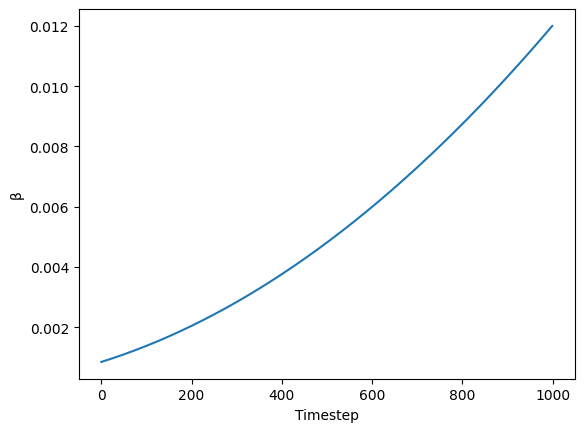

In [46]:
# a visualization of the schedule $\beta$ parameter
beta_start,beta_end = 0.00085,0.012
plt.plot(torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2)
plt.xlabel('Timestep')
plt.ylabel('β');

#### Models
---

In [6]:
# Load the variational autoencoder, that encode images into latents and to decode latent representations into images
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema") 

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
# hyper parameters match those used during training the model
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

# load pipelines to the choosen device
vae = vae.to(TORCH_DEVICE)
text_encoder = text_encoder.to(TORCH_DEVICE)
unet = unet.to(TORCH_DEVICE)
vae_const = 0.18215 # vae model trained with a scale term to get closer to unit variance

# Load RunwayML's Inpainting Model
inpainting = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting").to(TORCH_DEVICE)

/Users/a415083/anaconda3/envs/FastAip2/lib/python3.10/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/a415083/anaconda3/envs/FastAip2/lib/python3.10/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/a415083/anaconda3/envs/FastAip2/lib/python3.10/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  w

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/Users/a415083/anaconda3/envs/FastAip2/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [7]:
vae

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, ep

#### Functions

---

In [8]:
def img2latent(im, torch_dev=TORCH_DEVICE):
    im = transforms.ToTensor()(im).unsqueeze(0)
    with torch.no_grad():
        # encode the image into latent space through VAE
        latent = vae.encode(im.to(torch_dev) * 2 - 1 );
    latent = latent.latent_dist.sample() * vae_const      
    return latent
    
def latents2imgs(latents):
    # getting the latents from VAE (decoder layers)
    latents = latents * 1/vae_const
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    # let's convert images to PIL so we can display them.
    imgs = (imgs / 2 + 0.5).clamp(0,1)
    imgs = imgs.detach().cpu().permute(0,2,3,1).numpy()
    imgs = (imgs * 255).round().astype("uint8")
    imgs = [Image.fromarray(im) for im in imgs]
    return imgs
    
def get_embedding_for_prompt(prompt, torch_dev=TORCH_DEVICE):
    max_length = tokenizer.model_max_length
    tokens = tokenizer([prompt], padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
    with torch.no_grad(): # we are using for inference, no gradients needed
        embeddings = text_encoder(tokens.input_ids.to(torch_dev))[0]
    return embeddings

In [9]:
# Given a starting image latent and a prompt; predict the noise that should be removed to transform
# the noised source image to a denoised image guided by the prompt.
def predict_noise(text_embeddings, im_latents, seed=torch.seed(), guidance_scale=7, strength=0.5, torch_dev= TORCH_DEVICE, **kwargs):
    num_inference_steps = 50            # Number of denoising steps
    
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise

    uncond = get_embedding_for_prompt('')
    text_embeddings = torch.cat([uncond, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    offset = scheduler.config.get("steps_offset", 0)
    init_timestep = int(num_inference_steps * strength) + offset
    init_timestep = min(init_timestep, num_inference_steps)

    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps] * 1, device=torch_dev) # [timesteps] * 1 * 1

    start_step = init_timestep
    noise = torch.randn_like(im_latents)
    latents = scheduler.add_noise(im_latents, noise, timesteps=timesteps)
    latents = latents.to(torch_dev).float()

    t_start = max(num_inference_steps - init_timestep + offset, 0)
    timesteps = scheduler.timesteps[t_start:].to(torch_dev)

    noisy_latent = latents.clone()

    noise_pred = None
    for i, tm in enumerate(timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, tm)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, tm, encoder_hidden_states=text_embeddings)["sample"]

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        
        u = noise_pred_uncond
        g = guidance_scale
        t = noise_pred_text

        # perform guidance
        noise_pred = u + g * (t - u)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, tm, latents).prev_sample

    return latents2imgs(latents)[0], noise_pred

In [10]:
# For a given reference prompt and a query prompt;
# Run the diffusion process 10 times; Calculating a "noise distance" for each sample
def calc_diffedit_samples(encoded, prompt1, prompt2, n=10, **kwargs):
    diffs=[]
    # So we can reproduce mask generation we generate a list of n seeds
    torch.manual_seed(torch.seed() if 'seed' not in kwargs else kwargs['seed'])
    seeds = torch.randint(0,2 ** 62, (10,)).tolist()
    for i in range(n):
        kwargs['seed'] = seeds[i] # Important to use same seed for the two noise samples
        emb1 = get_embedding_for_prompt(prompt1)
        _im1,n1 = predict_noise(emb1, encoded, **kwargs)
        emb2 = get_embedding_for_prompt(prompt2)
        _im2,n2 = predict_noise(emb2, encoded, **kwargs)

        # Aggregate the channel components by taking the euclidean distance.
        diffs.append((n1 - n2)[0].pow(2).sum(dim=0).pow(0.5)[None])
    all_masks = torch.cat(diffs)
    return all_masks

# Given an image latent and two prompts; generate a grayscale diff by sampling the noise predictions
# between the prompts.
def calc_diffedit_diff(im_latent, p1, p2, **kwargs):
    m = calc_diffedit_samples(im_latent, p1, p2,**kwargs)
    m = m.mean(axis=0) # average samples together
    m = (m - m.min())/(m.max() - m.min()) # rescale to interval [0,1]
    m = (m * 255.).cpu().numpy().astype(np.uint8) # rescale to [0, 255]
    m = Image.fromarray(m)
    return m

# Try to improve the mask thrugh convolutions etc
# assume m is a PIL object containing a grayscale 'diff'
def process_diffedit_mask(m,threshold=0.35,**kwargs):
    m = np.array(m).astype(np.float32)
    m = cv2.GaussianBlur(m, (5, 5), 1)
    m = (m > (255.*threshold)).astype(np.float32)*255
    m = Image.fromarray(m.astype(np.uint8))
    return m

# Given an image latent and two prompts; generate a binarized mask (PIL) appropriate for inpainting
def calc_diffedit_mask(im_latent, p1, p2,**kwargs):
    m = calc_diffedit_diff(im_latent, p1, p2, **kwargs)
    m = process_diffedit_mask(m, **kwargs)
    m = m.resize((512, 512))
    return m

In [11]:
# Composite the mask over the provided image; for demonstration purposes
def get_blended_mask(im,mask_gray): # Both expected to be PIL images
    mask_rgb = mask_gray.convert('RGB')
    return Image.blend(im, mask_rgb, 0.40)
    
# Show the original image, the original image with mask and the resulting inpainted image
def demo_diffedit(im_path, p1, p2, torch_dev=TORCH_DEVICE, **kwargs):
    im_path = Path(im_path)
    out = []
    
    im = Image.open(im_path).resize((512,512))
    im_latent = img2latent(im)
    out.append(im)

    if 'seed' not in kwargs: kwargs['seed'] = torch.seed()
    mask = calc_diffedit_mask(im_latent, p1, p2,**kwargs)
    out.append(get_blended_mask(im, mask))
    out.append(inpainting(prompt=[p2], image=im, mask_image=mask, 
        generator=torch.Generator(torch_dev).manual_seed(kwargs['seed'])).images[0])
    show_images(out)

## Experiments/Results
---

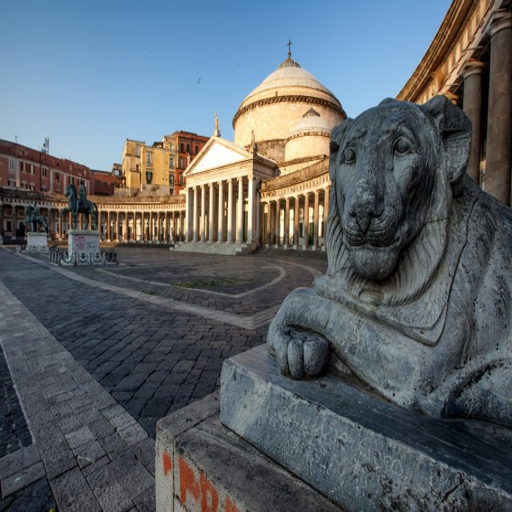

In [33]:
#Load an image
p = FastDownload().download('https://www.10cose.it/wp-content/uploads/2015/12/piazza-plebiscito-napoli-696x464.jpg')
im = Image.open(p).resize((512,512))
im

### Step-by-step

---

In [18]:
# We operate in latent space
latent = img2latent(im); latent.shape

torch.Size([1, 4, 64, 64])

seed: 12345678910111213141


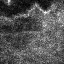

In [19]:
# !! This will take at least a few minutes.  The mask generation algorithm described in the DiffEdit paper !!
# !! requires that we run the stable diffusion ~20 times for a given pair of prompts.                      !!
seed = 12345678910111213141
#seed = torch.seed()
print('seed:',seed)
mask = calc_diffedit_diff(latent,'a lion statue','a dog statue',seed=seed)
mask # resample from 64x64 pixel mask to size of original image for ease of viewing

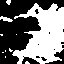

In [20]:
# we can take the gray scale diff mask and post process it to get our binarized mask
binarized_mask = process_diffedit_mask(mask)
binarized_mask

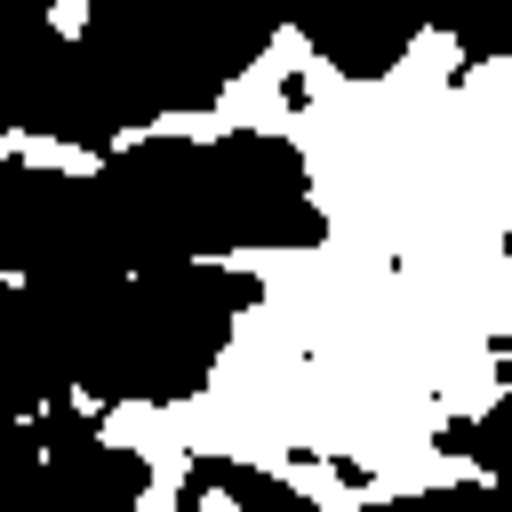

In [21]:
# In order to use the mask for inpainting we need to scale it back up from 64x64 to image size 512x512
binarized_mask = binarized_mask.resize((512,512))
binarized_mask

seed: 12345678910111213141


  0%|          | 0/50 [00:00<?, ?it/s]

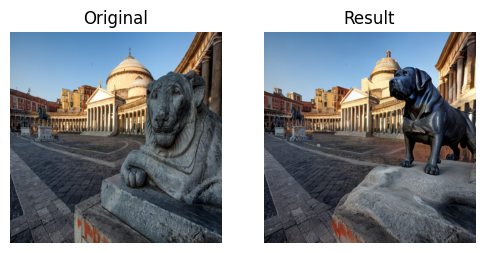

In [23]:
# Now we'll use the mask to do a stable diffusion in painting operation using our target prompt
seed = 12345678910111213141
#seed = torch.seed()
print('seed:',seed)
generator = torch.Generator(TORCH_DEVICE).manual_seed(seed)
im_result = inpainting(prompt=['a Neapolitan Mastiff statue '],image=im,mask_image=binarized_mask,generator=generator).images[0]
show_images([im,im_result],titles=['Original','Result'])

seed: 12345678910111213141


  0%|          | 0/50 [00:00<?, ?it/s]

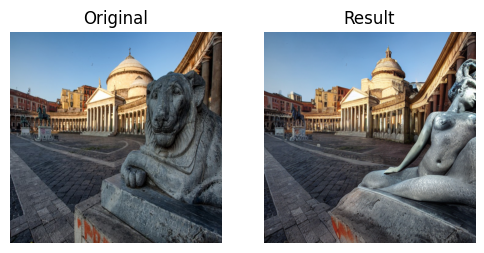

In [26]:
# Now we'll use the mask to do a stable diffusion in painting operation using our target prompt
seed = 12345678910111213141
#seed = torch.seed()
print('seed:',seed)
generator = torch.Generator(TORCH_DEVICE).manual_seed(seed)
im_result = inpainting(prompt=['a statue of a mermaid lying down'],image=im,mask_image=binarized_mask,generator=generator).images[0]
show_images([im,im_result],titles=['Original','Result'])

seeds: [12345678910111213144, 12345678910111213145, 12345678910111213146]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

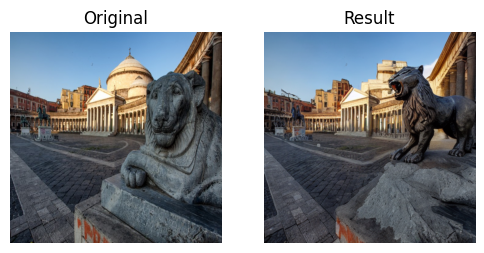

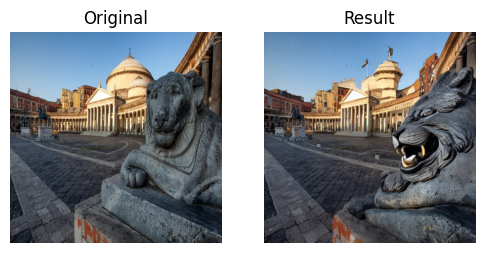

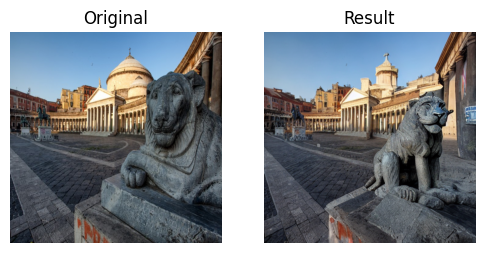

In [31]:
# combining the mask to stable diffusion to achieve the in painting operation using our target prompt
seeds = [
    12345678910111213144,
    12345678910111213145,
    12345678910111213146,
] 
#seed = torch.seed()
print('seeds:',seeds)
for seed in seeds:
    generator = torch.Generator(TORCH_DEVICE).manual_seed(seed)
    im_result = inpainting(prompt=['a statue of roaring lion'], image=im, mask_image=binarized_mask, generator=generator).images[0]
    show_images([im,im_result],titles=['Original','Result'])

In [32]:
from ipywidgets import interact,FloatSlider

def f(threshold):
    show_images([mask,process_diffedit_mask(mask,threshold)])
    return
    
interact(f,threshold=FloatSlider(min=0.,max=1.,value=0.35,step=0.05))

interactive(children=(FloatSlider(value=0.35, description='threshold', max=1.0, step=0.05), Output()), _dom_cl…

<function __main__.f(threshold)>

### High level - single function

---

seed: 12835639026266870718


('guitar', 'Saxophone')


  0%|          | 0/50 [00:00<?, ?it/s]

('guitar', 'Banjo')


  0%|          | 0/50 [00:00<?, ?it/s]

('guitar', 'a package of bricks of milk')


  0%|          | 0/50 [00:00<?, ?it/s]

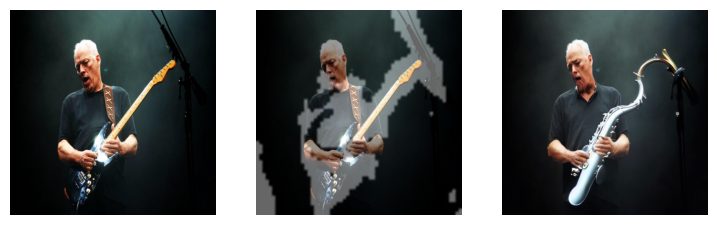

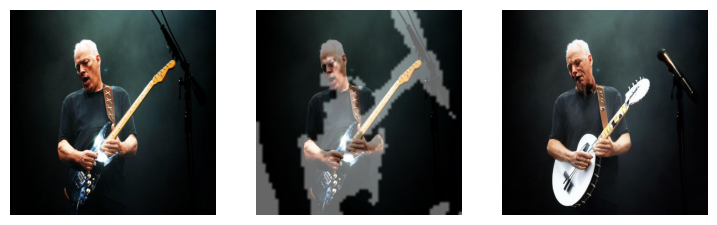

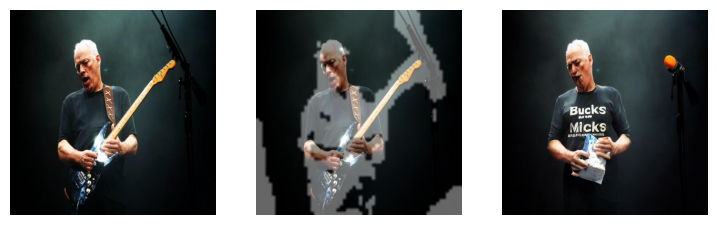

In [40]:
link = "https://www.virginradio.it/resizer/-1/-1/true/wp-content/uploads/2013/03/DG10.jpg--.jpg"
prompts = [
    ('guitar','Saxophone'),
    ('guitar','Banjo'),
    ('guitar','a package of bricks of milk')
]
seed=12835639026266870718

print('seed:',seed)
im_path = FastDownload().download(link)

for p in prompts: 
    print(p)
    demo_diffedit(im_path,*p,seed=seed) 

seed: 12835639026266870718
('guitar', 'bagpipe')


  0%|          | 0/50 [00:00<?, ?it/s]

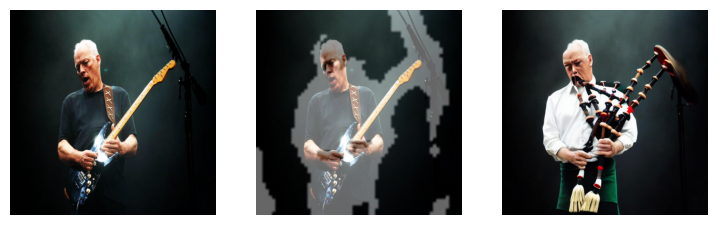

In [41]:
link = "https://www.virginradio.it/resizer/-1/-1/true/wp-content/uploads/2013/03/DG10.jpg--.jpg"
prompts = [
    ('guitar','bagpipe')
]
seed=12835639026266870718

print('seed:',seed)
im_path = FastDownload().download(link)

for p in prompts: 
    print(p)
    demo_diffedit(im_path,*p,seed=seed) 

seed: 12835639026266870719
('guitar', 'bagpipe')


  0%|          | 0/50 [00:00<?, ?it/s]

('guitar', 'white bagpipe')


  0%|          | 0/50 [00:00<?, ?it/s]

('guitar', 'black bagpipe')


  0%|          | 0/50 [00:00<?, ?it/s]

('guitar', 'red bagpipe')


  0%|          | 0/50 [00:00<?, ?it/s]

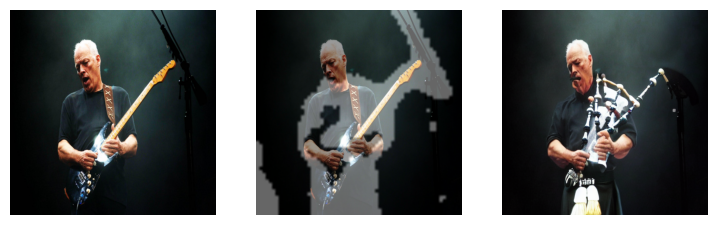

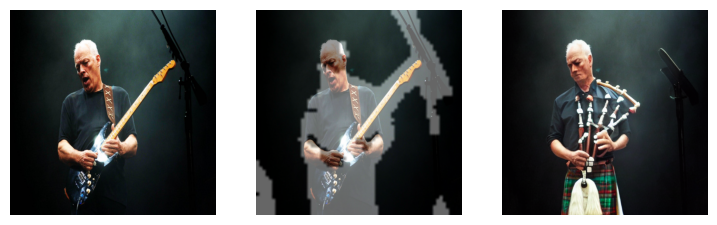

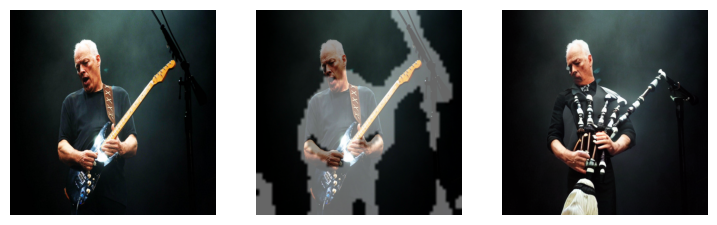

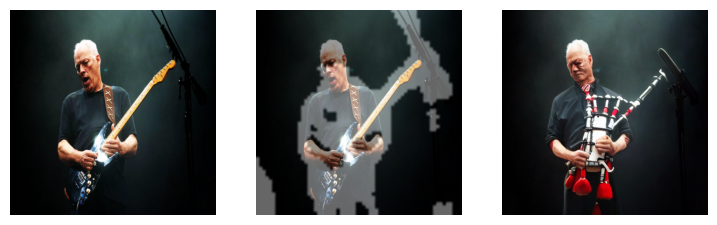

In [42]:
link = "https://www.virginradio.it/resizer/-1/-1/true/wp-content/uploads/2013/03/DG10.jpg--.jpg"
prompts = [
    ('guitar','bagpipe'),
    ('guitar','white bagpipe'),
    ('guitar','black bagpipe'),
    ('guitar','red bagpipe')
]
seed=12835639026266870719

print('seed:',seed)
im_path = FastDownload().download(link)

for p in prompts: 
    print(p)
    demo_diffedit(im_path,*p,seed=seed) 

In [ ]:
link = "https://www.virginradio.it/resizer/-1/-1/true/wp-content/uploads/2013/03/DG10.jpg--.jpg"
prompts = [
    ('guitar','bagpipe'),
    ('guitar','white bagpipe'),
    ('guitar','red bagpipe'),
]

seeds = [
    12345678910111213144,
    12345678910111213145,
    12345678910111213146,
] 
print('seeds:',seeds)
im_path = FastDownload().download(link)

for p, seed in zip(prompts, seeds): 
    print(p)
    demo_diffedit(im_path,*p,seed=seed) 

seeds: [12345678910111213144, 12345678910111213145, 12345678910111213146]
('guitar', 'bagpipe')


## Disclaimer
---

Disclaimer: 
this work on <a href="https://en.wikipedia.org/wiki/Diffusion_model">Diffusion Models</a> is based on <a href="https://arxiv.org/abs/2210.11427"> DiffEdit</a>, <a href="https://course.fast.ai/Lessons/part2.html"> FastAI Part 2  course</a> and related <a href="https://github.com/fastai/diffusion-nbs">diffusion nbs repo</a> as well as on <a href="https://github.com/johnrobinsn/diffusion_experiments/blob/main/DiffEdit.ipynb">this repo</a>.

More info on used pretrained models <a href="https://huggingface.co/">here</a>.
Images from google image search.